# Modal (Part 2)

---
✅ With all models and ChromaDB set up, it's time to integrate everything into a real system: **Snapr** — an app that scans online product listings, predicts their value, and alerts users to great deals.

To power SSnapr, we’ll need:
- Price prediction models — ready for production  
- Fast, on-demand predictions  
- A scalable setup that handles real-world usage

🔧 That’s where **Modal** comes in. Modal lets us deploy models and services to the cloud, with minimal setup, low latency, and clean Python APIs.

- You can check out a [live demo](https://huggingface.co/spaces/lisekarimi/snapr) of the project
- The source code is available on [GitHub](https://github.com/lisekarimi/snapr)

---
📢 Find more LLM notebooks on my [GitHub repository](https://github.com/lisekarimi/lexo)


## 📚 Pre-requisites

To follow this project smoothly, it's helpful to know:

- 🛰️ What an API is: You send a request → it’s processed remotely → you receive a result
- 🐳 What a Docker image & container are:
    - Image = environment with code & dependencies
    - Container = running instance of that image
- 🧑‍💻 Local vs Remote code execution:
    - Local code runs on your machine
    - Remote code runs in the cloud (via Modal

## 🔧  Install & Setup Modal
- Before starting, install Modal in your environment (Run this once): `uv pip install modal`
- Create an account at modal.com (they give you $5 free to start).
- Then authenticate your environment: `modal setup`

In [ ]:
!uv pip install modal

In [ ]:
import modal
import sys
sys.path.append(".")  # Make sure your local modules are accessible

## 🧠 Key Concepts

Modal is a platform that lets you run Python code in the cloud. You can:
- Deploy code as APIs
- Run GPU workloads (e.g., LLMs)
- Automatically handle Docker, infra, deployment

What is a Modal App?
An "App" is a containerized cloud service where you can run code remotely.
- Code runs in isolated containers (like Docker)
- These containers are created on-demand and destroyed when idle
- You define your logic in a file and deploy it to Modal

Key Modal Concepts
- `modal.Image`: Defines the environment (like a Docker image)
- `@app.cls`: Runs classes remotely inside a container
- `modal.App`: Defines and registers the Modal app
- `.remote()`: Sends request to Modal API to execute the code remotely
- `modal deploy -m`: Deploys app permanently like a real cloud service

## ⚙️ Minimal Example

In [ ]:
from modal_services.get_started import app, f

with app.run():  # This spins up a container in Modal
    print(f.local(1000))    # Run locally inside the notebook
    print('*' * 5)
    print(f.remote(1000))   # Run remotely via Modal API inside a container

🔄 What Happens When You Call .remote()?

some_function.remote() → Modal SDK sends API request
                    → Spins up a container
                    → Runs the code remotely
                    → Sends the result back to your local machine

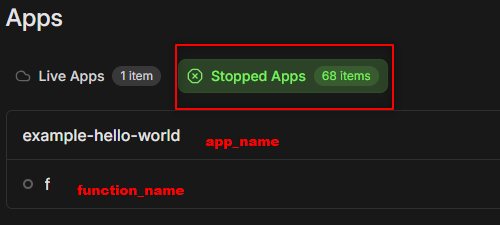

What we have here is an **ephemeral app**: the container shuts down after finishing.

For our project, we need a persistently running app that behaves like a production API. To achieve that, we should use `modal deploy -m`, making the app suitable for serving AI services reliably.

## 📦 Persistent Deployment with `modal deploy`

Click the blue "+" button at the top left of JupyterLab, then choose "Terminal" to open a new terminal tab.

There, you can run:

```bash
conda activate llms
modal deploy -m modal_services.get_started
```

This builds and deploys the app (`example-hello-world`), registers `f()`, and makes it callable via `.remote()` anytime — even outside the notebook.

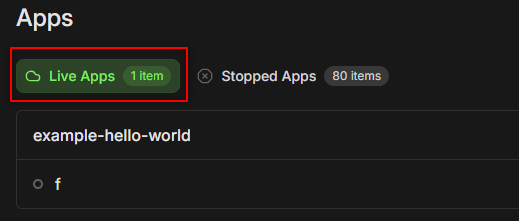

In [ ]:
from modal_services.get_started import f
f = modal.Function.from_name("example-hello-world", "f")  # (app_name, function_name)
print(f.remote(20))

## 🚀 Deploy Our first Modal-powered model

So far, we’ve seen how to run simple remote functions using `@app.function()` and call them via `modal.Function.from_name(...)` in a **persistent app** — good for basic tasks.

But in our Smart Deal Finder project, we need more:
- Load and reuse a large model (like LLaMA)  
- Keep the model in memory  
- Expose one or more methods (like `price()`)

That’s why we use `@app.cls` — it lets us define a class (e.g. `Pricer`) that lives in a Modal container, loads the model once in `setup()`, and handles remote requests efficiently.

Full code : `\modal_services.ft_pricer.py`

---


🚀 In this step, we’ll deploy a class-based app using `modal.Cls.from_name`.

Specifically, we’ll deploy `Pricer`, which loads our 4-bit quantized fine-tuned LLaMA model (trained in Notebook 9), and exposes a remote `.price()` method to estimate item prices.

⚠️ Before deploying, add your HF_TOKEN in Modal

Then open a terminal and run:

```bash
modal deploy -m modal_services.ft_pricer
```

This will:
- Build the image with your code and dependencies
- Deploy the app `llm-ft-pricer` and register the `Pricer` class and its methods
- Not start any container yet — setup() isn't run and the model isn’t loaded
- Prepare the app to handle `.remote()` calls when they come in

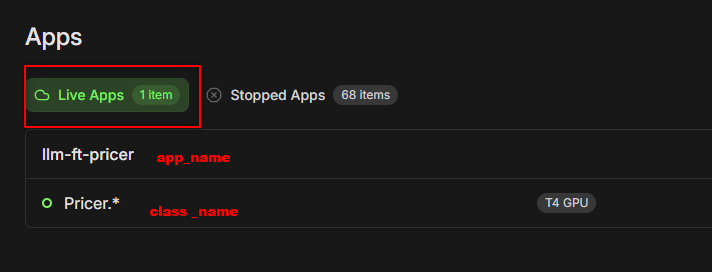

## 🔗 Connect to Our Deployed App

Now that our app is deployed, we can connect to it and use it like a remote service.

We'll do this using `modal.Cls.from_name("llm-ft-pricer", "Pricer")`, which fetches the `Pricer` class from our deployed app via the Modal API.

Then, calling `.price.remote(...)` sends a request to Modal, spins up a container if needed, loads the model, runs the method, and returns the result.

This is how we turn our model into a cloud API.

What happens under the hood when calling price.remote(...): 
- First run = downloads model files → stores in volume (/cache) → loads into memory → runs 
- Later runs = load from volume → memory → run (no re-download)

---

Since we added `min_containers=1`, a container is created and kept warm as soon as the app is deployed. Models remain loaded in memory, so there are no cold starts — unless the app is stopped or the container crashes.  

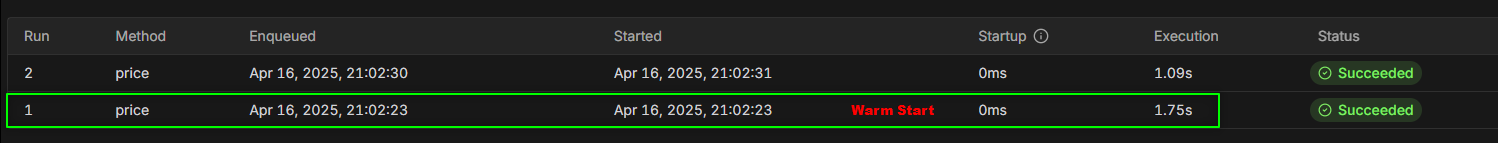

⚠️ However, this **continuously consumes credits** if you forget to stop the container or app manually.

To save credits, you can set `min_containers=0` and `scaledown_window=300` — this way, no container stays warm by default, and a new one will spin up only when `.remote()` is called (i.e., on cold start).

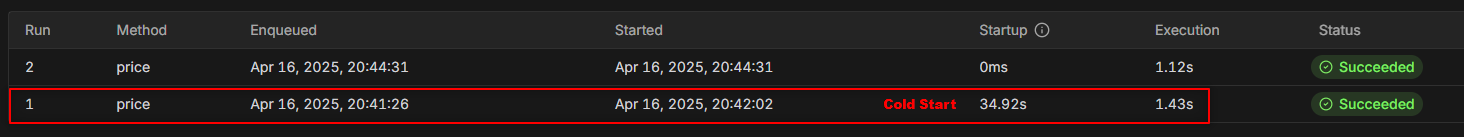


In [ ]:
Pricer = modal.Cls.from_name("llm-ft-pricer", "Pricer")
pricer = Pricer()
reply = pricer.price.remote("SEVERIN 28L Microwave, 900W, 5 power levels, 35-min timer, turntable (31.5 cm), Silver, MW 7772")
print(reply)

Now that we’ve deployed our model and learned how to call it remotely with `.remote()`,
let’s go one step further — wrap this logic inside a local Python class.

In the next step, we'll build a local Agent that cleanly interacts with our deployed `Modal app`, using the same `Modal API` under the hood.

## 🔌 Connect to Your Modal App with a Local Agent

`ft_pricer.py` is now a deployed API on Modal. 

To use it locally, we’ll wrap it in a class called `FTPriceAgent` (Full code: `\agents\ft_price_agent.py)` that:

- Connects to the remote app via `modal.Cls.from_name(...)`  
- Calls `.price.remote(...)` to run predictions  

🔄 **Two API Calls:** happen
1. `modal.Cls.from_name(...)` → fetches the deployed class  
2. `.price.remote(...)` → runs the remote method on Modal  

This keeps our code clean and modular.

In [ ]:
from agents.ft_price_agent import FTPriceAgent

agent = FTPriceAgent()
agent.price("Apple AirPods Max wireless over-ear headphones with active noise cancellation and spatial audio")

Now that we’ve seen how Modal agents work — connecting to remote services and running `.remote()` — we’ll use the same pattern for the rest of our models.

✅ For each model — **XGBoost**, **GPT-4o RAG**, and the **Ensemble** — we’ll build a dedicated Agent.  